# <font color='brown' size=4>Objective:</font> 
        
<p> This notebook explores different approaches for learning discriminative embeddings using popular algorithms from both text and image. We also get to explore about a concept called <b>Metric learning</b> which is very relevant for this competition</p>

> **📌 Note**: Here we gradually learn from basic representation to the advanced ones as always

<font color='brown' size=4>Ride on 🚀</font><br>

In [1]:
!pip install sentence_transformers
!pip install timm
!pip install -q pytorch-metric-learning[with-hooks]

     |████████████████████████████████| 64 kB 774 kB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-py3-none-any.whl size=103066 sha256=4adaf2e0e692ef7559ea291e7f8426fb3df95d51b898f02565414065a44cf0b4
  Stored in directory: /root/.cache/pip/wheels/1c/a2/db/5d9e7c4aa8dbd82718c202fb1bc7118c2d3bf0925af92943f2
Successfully built sentence-transformers
     |████████████████████████████████| 287 kB 1.2 MB/s 


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import logging
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, models
from torch import nn
from sentence_transformers.evaluation import BinaryClassificationEvaluator


import cv2
import torch.nn.init as init
import torch
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics
import urllib
import pickle
import cv2
import torch.nn.functional as F
from torchvision import models as torchmodels
import seaborn as sns
import random
import timm
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

import sys

%matplotlib inline
from pytorch_metric_learning import losses as pml_loss, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
import pytorch_metric_learning.utils.logging_presets as logging_presets
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s"%pytorch_metric_learning.__version__)

# Table of Contents

- 1. Embedding representations
   - 1.1 Text embeddings
   - 1.2 Image embeddings

- 2. Sbert overview
   - 2.1 Architecture
      
- 3. Introduction to metric learning
   - 3.1 Pytorch metric learning toolkit

- 4. Finetuning
   - 4.1 Sentence bert finetuning
   - 4.2 Pytorch metric learning(PML) for image embedding
   - 4.3 Custom pipeline + PML
       - 4.4 Utils
       - 4.5 Engine
       
- 5. Acknowledgements

# <font color='brown' size=4>1. Embedding representations</font>

<p>An image or text can be represented in many ways. But what makes it unique for the any machine learning model to learn is the distribution it learns underneath.</p> 
    

  <p>Ideally an embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together. An embedding can be learned and reused across models. </p>

## <font color='brown' size=4>1.1 Text embeddings</font>

<p> Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model.

Now, there are again many ways to do it, lets explain some of the basic ones and move to the recent advancements in the NLP world</p>

<b>One-hot encodings:</b>

As a first idea, you might "one-hot" encode each word in your vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, you will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src='https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1' width=1000>
<div align="center"><font size="3">Source: Google</font></div>

<b>Indexing words:</b>

A second approach you might try is to encode each word using a unique number. Continuing the example above, you could assign 1 to "cat", 2 to "mat", and so on. You could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, you now have a dense one (where all elements are full). But it also has downsides to it

<b>Word embeddings:</b>

Third approach is is word embeddings. Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer)

<img src='https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1' width=1000>
<div align="center"><font size="3">Source: Google</font></div>

> **📌 Note**: From the invention of word embeddings,n number of approaches came out to learn the representation from text. With the transformers ruling the NLP space, we will look into one of its architecture which has been specifically designed for learning sentence representation

## <font color='brown' size=4>1.2 Image embeddings</font>

<p> Image embeddings are lot more intuitive than text, in a lot of use cases we can either use the pretrained models like VGG,Resnet,Effnet to get features out of it or finetune a model for custom use and use it for lot of exciting applications like similarity match,image retrieval etc </p>

> **📌 Note**: Lot of pretrained backbone models can be used for getting embeddings, here we will train efficientnet and resnet based model with metric learning to learn the image embeddings from our product images

# <font color='brown' size=4>2. Sbert overview</font>

<p>Sentence-BERT (SBERT), a modification of the BERT network uses siamese and triplet networks to derive semantically meaningful sentence embeddings
    
For sentence / text embeddings, we want to map a variable length input text to a fixed sized dense vector. The most basic network architecture we can use is the following:
</p>

<img src='https://www.sbert.net/_images/SBERT_Architecture.png' width=1000>
<div align="center"><font size="3">Source: Sbert</font></div>


> **📌 Note**: We feed the input sentence or text into a transformer network like BERT. BERT produces contextualized word embeddings for all input tokens in our text. As we want a fixed-sized output representation (vector u), we need a pooling layer. Different pooling options are available, the most basic one is mean-pooling: We simply average all contextualized word embeddings BERT is giving us. This gives us a fixed 768 dimensional output vector independet how long our input text was.

## <font color='brown' size=4>2.1 Architecture</font>

<p>The most simple way is to have sentence pairs annotated with a score indicating their similarity, e.g. on a scale 0 to 1. We can then train the network with a Siamese Network Architecture</p>

<img src='https://www.sbert.net/_images/SBERT_Siamese_Network1.png' width=1000>
<div align="center"><font size="3">Source: Sbert</font></div>

> **📌 Note**: For each sentence pair, we pass sentence A and sentence B through our network which yields the embeddings u und v. The similarity of these embeddings is computed using cosine similarity and the result is compared to the gold similarity score. This allows our network to be fine-tuned and to recognize the similarity of sentences.

# <font color='brown' size=4>3. Introduction to metric learning</font>

<p>The goal of Metric Learning is to learn a representation function that maps objects into an embedded space. The distance in the embedded space should preserve the objects’ similarity — similar objects get close and dissimilar objects get far away. Various loss functions have been developed for Metric Learning.</p>
    
   <p>For example, the <b>contrastive loss</b> guides the objects from the same class to be mapped to the same point and those from different classes to be mapped to different points whose distances are larger than a margin. <b>Triplet loss</b> is also popular, which requires the distance between the anchor sample and the positive sample to be smaller than the distance between the anchor sample and the negative sample.</p>

## <font color='brown' size=4>3.1 Pytorch metric learning toolkit</font>

<p>PyTorch Metric Learning is an open source library that aims to do metric based learning elegantly. The modular and flexible design allows users to easily try out different combinations of algorithms in their existing code. It also comes with complete train/test workflows, for users who want results fast.</p>

**Major components:**

* Miners: Determine the best way to create batches
* Losses: Loss functions work similarly to many regular PyTorch loss functions
* Distances: Distance metrics used in loss function for comparison of embeddings
* Reducers: Losses are typically computed per element, pair, or triplet, and are then                   reduced to a single value by some operation, such as averaging

<img src='https://kevinmusgrave.github.io/pytorch-metric-learning/imgs/high_level_loss_function_overview.png' width=1000>
<div align="center"><font size="3">Source: PML</font></div>

> **📌 Note**: Please refer to their documentation for detailed explanation, link is attached in the acknowledgement section

# <font color='brown' size=4>4. Finetuning</font>

<p>Let's now finetune text and images of the product to get more relevant embeddings which can later be used for finding similarity</p>

## <font color='brown' size=4>4.1 Sentence bert finetuning</font>

<b>Dataset credit</b> : https://www.kaggle.com/tanulsingh077/shopee-siamese-training

In [3]:
train_df=pd.read_csv('../input/shopee-product-matching/train.csv')
test_df=pd.read_csv('../input/shopee-product-matching/test.csv')
siam_data=pd.read_csv('../input/shopee-siamese-training/siamese_data.csv')

train_image_path='../input/shopee-product-matching/train_images/'

siam_data['image_1_path']=siam_data['image_1'].apply(lambda x: train_image_path+x)
siam_data['image_2_path']=siam_data['image_2'].apply(lambda x: train_image_path+x)

train_df['image_path']=train_df['image'].apply(lambda x: train_image_path+x)
labels_list=train_df['label_group'].value_counts().index[:100].tolist() ##filtering only 100 labels

train_df=train_df[train_df['label_group'].isin(labels_list)].reset_index(drop=True)

In [4]:
siam_data.head(2)

,posting_id_1,posting_id_2,title_1,title_2,image_1,image_2,label,image_1_path,image_2_path
0,train_129225211,train_2278313361,Paper Bag Victoria Secret,PAPER BAG VICTORIA SECRET,0000a68812bc7e98c42888dfb1c07da0.jpg,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,1,../input/shopee-product-matching/train_images/...,../input/shopee-product-matching/train_images/...
1,train_129225211,train_866245802,Paper Bag Victoria Secret,BGSR Jaket Cagoule / Jaket Cagoule Premium / J...,0000a68812bc7e98c42888dfb1c07da0.jpg,5b9a1c01bf01447982a8f0a593909d07.jpg,0,../input/shopee-product-matching/train_images/...,../input/shopee-product-matching/train_images/...


In [5]:
siam_data['label'].value_counts()

0    34832
1    20874
Name: label, dtype: int64

In [6]:
#shuffle the data for split
siam_data=siam_data.sample(frac=0.5).reset_index(drop=True) #taking only sample of data
train,val = train_test_split(siam_data, test_size=0.2, random_state=42,
                                                       stratify=siam_data['label'])

In [7]:
model_name = 'bert-base-uncased'
train_batch_size = 16
num_epochs = 1
model_save_path = 'output/training_stsbenchmark_continue_training-'+model_name+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [8]:
#Get the bert base uncased embedding and pass it into pooling layer and a linear layer for findal representation
word_embedding_model = models.Transformer(model_name, max_seq_length=512)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=512, activation_function=nn.Tanh())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
#Prepare dataset
train_samples = []
val_samples = []

for row in train.iterrows():
        inp_example = InputExample(texts=[row[1]['title_1'], row[1]['title_2']], label=row[1]['label'])
        train_samples.append(inp_example)         

for row in val.iterrows():
        inp_example = InputExample(texts=[row[1]['title_1'], row[1]['title_2']], label=row[1]['label'])
        val_samples.append(inp_example)   

In [10]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.ContrastiveLoss(model=model)


# Development set: Measure correlation between cosine score and gold labels
logging.info("Read evaluation dev dataset")
evaluator = BinaryClassificationEvaluator.from_input_examples(val_samples, name='contrast-dev')


# Configure the training. We skip evaluation in this example
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1393 [00:00<?, ?it/s]

## <font color='brown' size=4>4.2 Pytorch metric learning(PML) for image embedding</font>

> **📌 Note**: Here we will train the model using metric learning, So that same class gets similar representation, this can be even tried with siamese architecture

In [11]:
#Dummy model for the pipeline building, it can be replaced with any model

class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.resnet18(pretrained=True) #any model can be used as trunk/backbone
trunk_output_size = trunk.fc.in_features
trunk.fc = common_functions.Identity()
trunk = trunk.to(device)

# Set embedder model. This takes in the output of the trunk and outputs 512 dimensional embeddings
embedder = MLP([trunk_output_size, 512]).to(device)

# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.00001, weight_decay=0.0001)
embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=0.0001, weight_decay=0.0001)

# Set the image transforms
train_transform = transforms.Compose([transforms.Resize(512),
                                    transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=64),
                                    transforms.RandomHorizontalFlip(0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize(512),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### <font color='brown' size=4>Transforms</font>

In [13]:
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=120, p=0.8),
            albumentations.RandomBrightness(limit=(0.09, 0.6), p=0.5),
            albumentations.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
            albumentations.ShiftScaleRotate(
                shift_limit=0.25, scale_limit=0.1, rotate_limit=0
            ),
            albumentations.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], max_pixel_value=255.0, always_apply=True
            ),
        
            ToTensorV2(p=1.0),
        ]
    )

def get_valid_transforms():

    return albumentations.Compose(
        [albumentations.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], max_pixel_value=255.0, always_apply=True),
        ToTensorV2(p=1.0)
        ]
    )


### <font color='brown' size=4>Dataset</font>

In [14]:
class MyDataset(Dataset):
    
    def __init__(self, dataframe,dim=(512,512), transform=None, test=False):
        self.df = dataframe
        self.transform = transform
        self.test = test
        self.dim=dim
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        label = self.df.label.values[idx]
        p_path = self.df.image_path.values[idx]
        
            
        image = cv2.imread(p_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        #image = transforms.ToPILImage()(image)
        if self.dim:
            image = cv2.resize(image,self.dim)
            
        if self.transform:
            image = self.transform(image=image)
        
        return image['image'], label

In [15]:
le = preprocessing.LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label_group'])

In [16]:
train_data,val_data = train_test_split(train_df, test_size=0.4, random_state=42,
                                                       stratify=train_df['label'])

train_dataset=MyDataset(train_data,transform=get_train_transforms())
val_dataset=MyDataset(val_data,transform=get_valid_transforms())

In [17]:
# Set the loss function, here i use triplet loss
loss = pml_loss.TripletMarginLoss(margin=0.1)

# Set the mining function
miner = miners.MultiSimilarityMiner(epsilon=0.1)

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(train_data.label, m=4, length_before_new_iter=len(train_data))

# Set other training parameters
batch_size = 32
num_epochs = 1

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

In [18]:
record_keeper, _, _ = logging_presets.get_record_keeper("example_logs", "example_tensorboard")
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": val_dataset}
model_folder = "example_saved_models"

#To visualize the embeddings of different classes after one epoch training
def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info("UMAP plot for the {} split and label set {}".format(split_name, keyname))
    label_set = np.unique(labels)
    num_classes = len(label_set)
    fig = plt.figure(figsize=(20,15))
    plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)   
    plt.show()

# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook = hooks.end_of_testing_hook, 
                                            visualizer = umap.UMAP(), 
                                            visualizer_hook = visualizer_hook,
                                            dataloader_num_workers = 4)

end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                            dataset_dict, 
                                            model_folder, 
                                            test_interval = 1,
                                            patience = 1)

In [19]:
trainer = trainers.MetricLossOnly(models,
                                optimizers,
                                batch_size,
                                loss_funcs,
                                mining_funcs,
                                train_dataset,
                                sampler=sampler,
                                dataloader_num_workers = 4,
                                end_of_iteration_hook = hooks.end_of_iteration_hook,
                                end_of_epoch_hook = end_of_epoch_hook)

100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


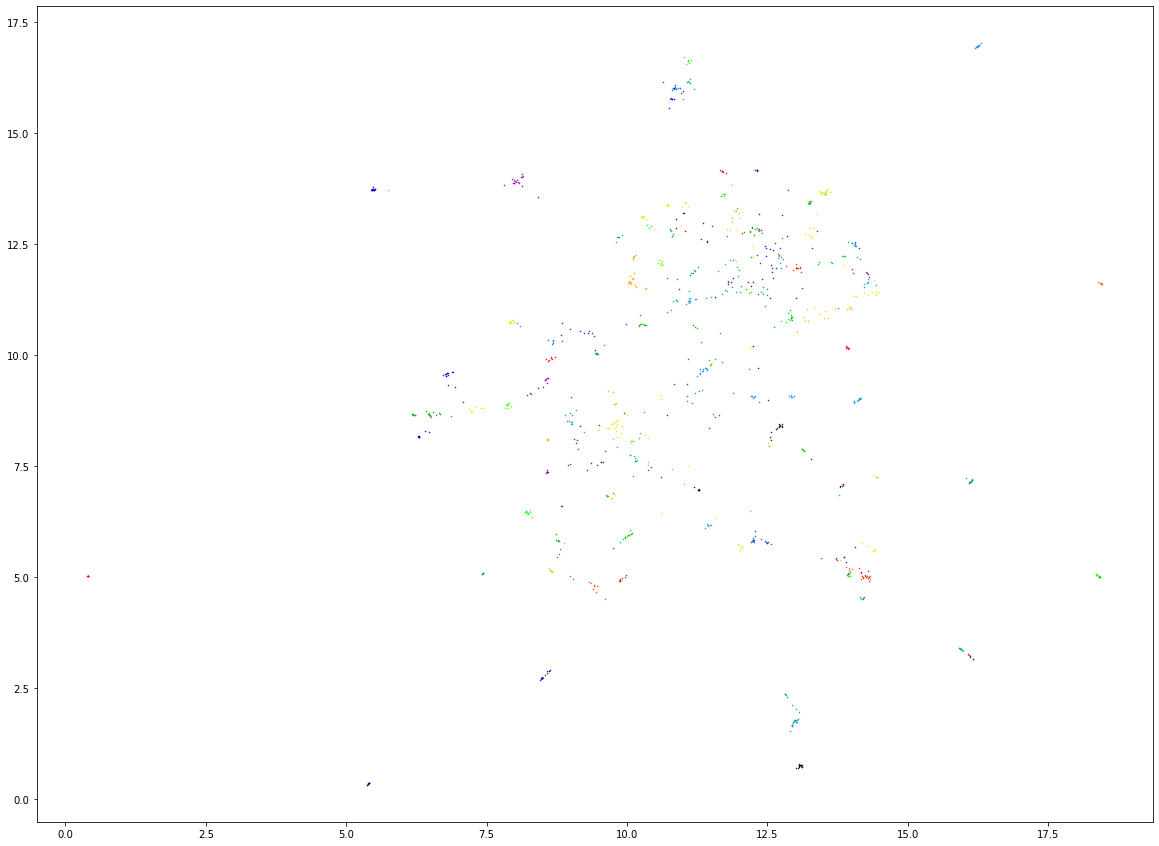

In [20]:
trainer.train(num_epochs=num_epochs)

# <font color='brown' size=4>4.3 Custom pipeline + PML</font>

> **📌 Note**: Here we use metric learning but with our custom model with effnet backbone

Reference: https://www.kaggle.com/tanulsingh077/siamese-style-training-efficient-net-b0

## <font color='brown' size=4>4.4 Utils</font>

In [21]:
DIM = (512,512)

NUM_WORKERS = 4
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 1
SEED = 2020
LR = 3e-4


DEVICE = "cuda"

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


################################################# MODEL ####################################################################

MODEL_NAME = 'efficientnet_b0' #efficientnet_b3 #efficientnetb5 #efficientnetb7

SCHEDULER = 'CosineAnnealingWarmRestarts' #'CosineAnnealingLR'
T_0=3 # CosineAnnealingWarmRestarts
min_lr=1e-6

In [22]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [23]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [24]:
class SiameseModel(nn.Module):
    def __init__(self, model_name='efficientnet_b0',out_features=2,pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        
        self.model.global_pool = nn.Identity()
        self.model.classifier = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(nn.Linear(n_features, n_features//2),
                                nn.ReLU(),
                                nn.Linear(n_features//2, out_features)
                                )

    def forward(self, x):
        bs = x.size(0)
        output = self.model(x)
        output = self.pooling(output).view(bs, -1)
        
        output = self.classifier(output)
        return output

## <font color='brown' size=4>4.5 Engine</font>

In [25]:
def train_fn(dataloader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    loss_score = AverageMeter()
    
    tk0 = tqdm(dataloader, total=len(dataloader))
    for img_0,label in tk0:
        
        img_0 = img_0.to(device)

        label = label.to(device)
        
        batch_size = img_0.shape[0]
        
        optimizer.zero_grad()
        
        output_1 = model(img_0)
        
        loss = criterion(output_1,label)
        
        loss.backward()
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        loss_score.update(loss.detach().item(), batch_size)
        
        
        tk0.set_postfix(Train_Loss=loss_score.avg,Epoch=epoch)
        
    return loss_score

In [26]:
def run():
    df=pd.read_csv('../input/shopee-product-matching/train.csv')
    df['image_path']=df['image'].apply(lambda x: train_image_path+x)
    df=df.sample(frac=0.5).reset_index(drop=True) #taking only sample of data
    
    df['label'] = le.fit_transform(df['label_group'])
    
    # Defining DataSet
    train_dataset = MyDataset(df,transform=get_train_transforms())
        
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        pin_memory=True,
        drop_last=True,
        num_workers=NUM_WORKERS
    )
    
    # Defining Device
    device = torch.device("cuda")
    
    # Defining Model for specific fold
    model = SiameseModel(model_name=MODEL_NAME,out_features=128,pretrained=False)
    model.to(device)
    
    #DEfining criterion - using arcface loss
    criterion = pml_loss.ArcFaceLoss(num_classes=11014,embedding_size=128)

    optimizer = torch.optim.Adam(criterion.parameters(), lr=LR)
    #Defining LR SCheduler
    scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=T_0)
    
    # THE ENGINE LOOP
    best_loss = 10000
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_loader, model,criterion, optimizer, device,scheduler=scheduler,epoch=epoch)
        
        if train_loss.avg < best_loss:
            best_loss = train_loss.avg
            torch.save(model.state_dict(),f'model_best_loss.bin')

In [27]:
run()

100%|██████████| 1070/1070 [07:01<00:00,  2.54it/s, Epoch=0, Train_Loss=49.8]


#### <b>Cheers, happy kaggling!!!</b>

# <font color='brown' size=4>5. Acknowledgements</font>

* https://www.tensorflow.org/tutorials/text/word_embeddings
* https://www.sbert.net/docs/training/overview.html
* https://kevinmusgrave.github.io/pytorch-metric-learning/